By Danilo Aballay, Federico Fuentes, Vicente Iligaray, Ángel J. Omella, David Pardo, Manuel A. Sánchez, Ignacio Tapia, Carlos Uriarte



In [1]:
# Import libraries
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import pandas as pd

os.environ["KERAS_BACKEND"] = "jax"

import keras

from fem_system import solve_and_loss, solve
from r_adaptivity_NN import make_model, make_loss_model, lr_schedule, tricky_loss

# Set the random seed
np.random.seed(1234)
keras.utils.set_random_seed(1234)

dtype='float64' # double precision set to default in the SCR functions
jax.config.update("jax_enable_x64", True)
keras.backend.set_floatx(dtype)

/home/vicente/miniconda3/envs/course/lib/python3.12/site-packages/numpy/core/getlimits.py:542: UserWarning: Signature b'\x00\xd0\xcc\xcc\xcc\xcc\xcc\xcc\xfb\xbf\x00\x00\x00\x00\x00\x00' for <class 'numpy.longdouble'> does not match any known type: falling back to type probe function.
This warnings indicates broken support for the dtype!
  machar = _get_machar(dtype)
An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [2]:
from scipy.integrate import dblquad, quad

def Exact_Ritz():
    alpha = 10
    s = 0.05
    f = lambda x, y: (np.arctan(alpha*(y - s)) + np.arctan(alpha*s))*2*alpha**2*(alpha*(x-s))/(1 + (alpha*(x - s))**2)**2 \
                        + (jnp.atan(alpha*(x - s)) + np.arctan(alpha*s))*2*alpha**2*(alpha*(y-s))/(1 + (alpha*(y - s))**2)**2
    u = lambda x, y: (np.arctan(alpha*(x - s)) + np.arctan(alpha*s))*(np.arctan(alpha*(y - s)) + np.arctan(alpha*s))
    gu  = lambda x, y: (np.arctan(alpha*(x-s)) + np.arctan(alpha*s)) * alpha / (1 + (alpha*(y-s))**2)
    gt = lambda x, y: (np.arctan(alpha*(y-s)) + np.arctan(alpha*s)) * alpha / (1 + (alpha*(x-s))**2)
    gradu = lambda x, y: gu(x, y)**2 + gt(x, y)**2

    neum1 = quad(lambda x: u(x, 1)*gu(x, 1), 0, 1)
    neum2 = quad(lambda x: u(1, x)*gt(1, x), 0, 1)

    fun = lambda y, x: 0.5*gradu(x, y) - u(x, y)*f(x, y) 
    exact_ritz = dblquad(fun, 0, 1, 0, 1)[0] - neum1[0] - neum2[0]
    return exact_ritz

In [3]:
# Create the model
# Number of neurons 
nn = 2*16
# Number of training iterations
iterations = 1500

# Initialize the neural network model for the approximate solution
model = make_model(nn)
# Save initial nodes
init_nodes = model(jnp.array([1]))
# Create loss model
loss_model = make_loss_model(model)
# Optimizer (Adam optimizer with a specific learning rate)
optimizer = keras.optimizers.Adam(learning_rate=1e-2)
# Learning rate schedule
lr_scheduler = keras.callbacks.LearningRateScheduler(lr_schedule)
# Compile the loss model with a custom loss function (tricky_loss)
loss_model.compile(optimizer=optimizer, loss=tricky_loss)

/home/vicente/miniconda3/envs/course/lib/python3.12/site-packages/jax/_src/ops/scatter.py:92: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int64 to dtype=int32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(


In [4]:
# Train the model
start_time = time.time()
history    = loss_model.fit(jnp.array([1.]), jnp.array([1.]), epochs=iterations, callbacks = [lr_scheduler], verbose=0)
end_time   = time.time() 
print('Training time: ', end_time - start_time)

Training time:  17.706964015960693


e_h: 0.1118200282039304
e_theta: 0.054834780359616815


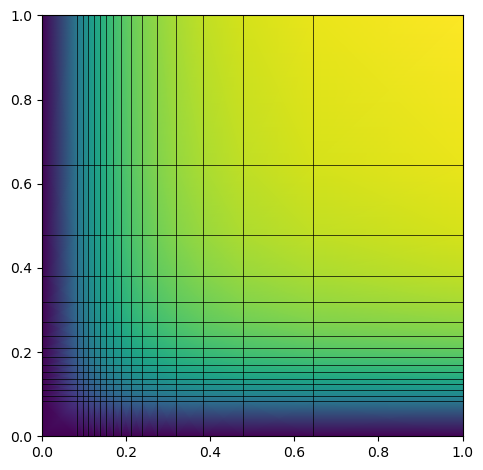

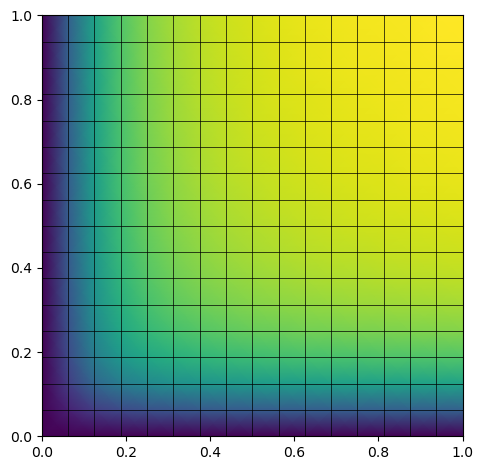

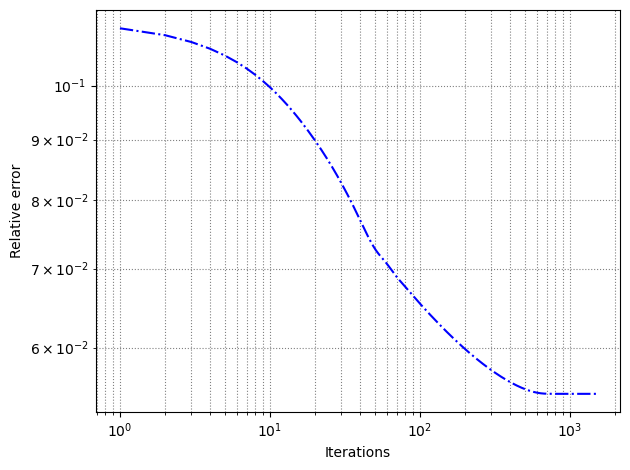

In [ ]:
# Plot results
uniform_nodes = jnp.concatenate([jnp.linspace(0, 1, nn//2 + 1), jnp.linspace(0, 1, nn//2 + 1)])

node_coords, u = solve(model(jnp.array([1])))
uniform_coords, o = solve(uniform_nodes)

J_u_theta = np.array(history.history['loss'])
J_u       = Exact_Ritz()
J_u_h = solve_and_loss(uniform_nodes)
rel_error_theta = np.sqrt((J_u - J_u_theta)/J_u)
rel_error_h = np.sqrt((J_u - J_u_h)/J_u)
print('e_h:', rel_error_h)
print('e_theta:', rel_error_theta[-1])

# Plot the approximate solution obtained from the trained model
plt.figure(1)
plt.pcolormesh(node_coords[:,0].reshape(nn//2+1,nn//2+1), node_coords[:,1].reshape(nn//2+1,nn//2+1), u.reshape(nn//2+1,nn//2+1), shading='gouraud')
unique_x = np.unique(node_coords[:,0])
unique_y = np.unique(node_coords[:,1])
for xi in unique_x:
    plt.plot([xi] * len(unique_y), unique_y, color='black', linewidth=0.5)
for yi in unique_y:
    plt.plot(unique_x, [yi] * len(unique_x), color='black', linewidth=0.5) 
plt.gca().set_aspect('equal') 
plt.tight_layout()

# Plot the approximate solution obtained from the uniform mesh
plt.figure(2)
plt.pcolormesh(uniform_coords[:,0].reshape(nn//2+1,nn//2+1), uniform_coords[:,1].reshape(nn//2+1,nn//2+1), o.reshape(nn//2+1,nn//2+1), shading='gouraud')
unique_x = np.unique(uniform_coords[:,0])
unique_y = np.unique(uniform_coords[:,1])
for xi in unique_x:
    plt.plot([xi] * len(unique_y), unique_y, color='black', linewidth=0.5)
for yi in unique_y:
    plt.plot(unique_x, [yi] * len(unique_x), color='black', linewidth=0.5) 
plt.gca().set_aspect('equal')
plt.tight_layout()

# Plot the relative error
plt.figure(3)
plt.loglog(np.arange(1,iterations+1), rel_error_theta,'-.', color='b')
plt.xlabel('Iterations')
plt.ylabel('Relative error')
plt.grid(which = 'both', axis = 'both', linestyle = ':', color = 'gray')
plt.tight_layout()

plt.show()